_**Computational Tools for Data Science** - Final Project  | December 2022_

Lluis Colomer (s21323)- Anna Rifé (s212487)- Alex Abades (s212784) - Dani Arriazu (s212792)

In [1]:
#All the necessary packages we used for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
from ttictoc import tic,toc
import networkx as nx
import seaborn as sns
import re as re
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.centrality import edge_betweenness_centrality
from networkx.algorithms.community.quality import modularity
import community.community_louvain
import operator
from fa2l import force_atlas2_layout
from wordcloud import WordCloud
import warnings
from collections import Counter


# Packages for clustering
import os
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

# <font color='darkgreen'> <center> <h3>Recommendation System of common food and its nutrients based on network graphs. </h3> </center>
# <font color='green'> <center> <h4>Computational Tools for Data Science</h4> </center>

## <font color='darkgreen'> 1. Motivation   
    
### <font color='green'> 1.1 _Our Dataset:_
The chosen dataset consists on a list of approximately 8.8k food entries with their corresponding nutritional values. The food composition of each ingredient has been determined based on the same serving size, i.e. 100g. 
Excluding the name and the serving size, the total amount of relevant features is 75. Notice that the following analysis does not exclude any nutritient a priori.
The dataset can be easily found in Kaggle as: [Nutritional values for common foods and products](https://www.kaggle.com/datasets/trolukovich/nutritional-values-for-common-foods-and-products).
    
    
### <font color='green'> 1.2 _Our Goals:_
This project covers some of the relevant tools for data science developed during the course *Computational tools for data science* as well as a few others not directly taught in the lectures. These are listed below: 

* Python and build-in packages (Pandas, Numpy, MatplotLib...)
* Hierarchical clustering 
* Social-Networks graphs using the networkx library and the use of Girvan-Newman,  Louvain heuristices and Spectral Clustering algorithms for finding communities based on modularity scores. 
* Recommendation System based on the neighbourhood of the network.

Moreover, beyond the scope of this course, the following tools were used which were not direclty taught in this course:
* World Clouds
* Weighted Network
* Louvain heuristices to find communities
* Recommendation System based on graphs instead of the using the Apriori Algorithm to find association rules


All those tools have been implemented in order to achieved some pre-defined goals based on the chosen dataset, being the following ones: 
1. Define an strategy to deal with missing values (NaN) of our chosen Food dataset. 
2. Determine an association criteria to build a Social-Network graph based on two types of nodes: **nutrients** and **common foods and products**.
3. Establish recommendation systems based on the built network, being the following ones: 
    * Recommend aliments rich in one nutrient based its neighbourdhood. 
    * Recommend better substitues of aliments one could eat based on the neighbourhood of its neighbourdhood.  
 
    
Throughout this notebook and the report, a deeper understanding of each issue-goal is given.

## <font color='darkgreen'> 2. Preprocessing and Data Cleaning
### <font color='green'> 2.1 _Pre-cleaning of the dataset:_
First of all, the foods and products dataset were imported as a Pandas dataframe for convenience. Right after, due to a few intrinsic errors, the unit term that follows the numerical value of each observation/nutrient was omitted. Finally, all columns but *name* were converted to **float32** type and the redundant feature *serving_size* was excluded since any added information was given but just the fact that the serving size of each food was 100g. 

In [2]:
df = pd.read_csv("data/nutrition.csv", index_col = 0)
df.head()

name serving_size  calories total_fat saturated_fat cholesterol  \
0       Cornstarch        100 g       381      0.1g           NaN           0   
1     Nuts, pecans        100 g       691       72g          6.2g           0   
2    Eggplant, raw        100 g        25      0.2g           NaN           0   
3   Teff, uncooked        100 g       367      2.4g          0.4g           0   
4  Sherbet, orange        100 g       144        2g          1.2g         1mg   

     sodium  choline     folate folic_acid  ...      fat  \
0   9.00 mg   0.4 mg   0.00 mcg   0.00 mcg  ...   0.05 g   
1   0.00 mg  40.5 mg  22.00 mcg   0.00 mcg  ...  71.97 g   
2   2.00 mg   6.9 mg  22.00 mcg   0.00 mcg  ...   0.18 g   
3  12.00 mg  13.1 mg          0          0  ...   2.38 g   
4  46.00 mg   7.7 mg   4.00 mcg   0.00 mcg  ...   2.00 g   

  saturated_fatty_acids monounsaturated_fatty_acids  \
0               0.009 g                     0.016 g   
1               6.180 g                    40.801 g   
2               0.034 g                     0.016 g   
3               0.449 g                     0.589 g   
4               1.160 g                     0.530 g   

  polyunsaturated_fatty_acids fatty_acids_total_trans alcohol     ash  \
0                     0.025 g                 0.00 mg   0.0 g  0.09 g   
1                    21.614 g                 0.00 mg   0.0 g  1.49 g   
2                     0.076 g                 0.00 mg   0.0 g  0.66 g   
3                     1.071 g                       0       0  2.37 g   
4                     0.080 g                 1.00 mg   0.0 g  0.40 g   

  caffeine theobromine    water  
0  0.00 mg     0.00 mg   8.32 g  
1  0.00 mg     0.00 mg   3.52 g  
2  0.00 mg     0.00 mg  92.30 g  
3        0           0   8.82 g  
4  0.00 mg     0.00 mg  66.10 g  

[5 rows x 76 columns]

In [3]:
# It is compulsory to get rid of the label of the unit in each data element.
# We require either int, float or bool rather than string to operate correctly.
def obtain_val(string):
    val = re.findall('\d*\.?\d+',string)
    return "".join(val)

df.drop(['serving_size'], axis=1)
#df['total_fat']=df['total_fat'].apply(lambda x: obtain_val(x)).astype(float)
df2 = df.filter(['name'], axis=1)
df = df.drop(columns=['name'])

df = df.astype(str)

#df = df.replace("",0)
df = df.applymap(obtain_val)
df = df.mask(df == '')
df = df.astype(float)
df2 = df2.join(df)

df2.head()

name  serving_size  calories  total_fat  saturated_fat  \
0       Cornstarch         100.0     381.0        0.1            NaN   
1     Nuts, pecans         100.0     691.0       72.0            6.2   
2    Eggplant, raw         100.0      25.0        0.2            NaN   
3   Teff, uncooked         100.0     367.0        2.4            0.4   
4  Sherbet, orange         100.0     144.0        2.0            1.2   

   cholesterol  sodium  choline  folate  folic_acid  ...    fat  \
0          0.0     9.0      0.4     0.0         0.0  ...   0.05   
1          0.0     0.0     40.5    22.0         0.0  ...  71.97   
2          0.0     2.0      6.9    22.0         0.0  ...   0.18   
3          0.0    12.0     13.1     0.0         0.0  ...   2.38   
4          1.0    46.0      7.7     4.0         0.0  ...   2.00   

   saturated_fatty_acids  monounsaturated_fatty_acids  \
0                  0.009                        0.016   
1                  6.180                       40.801   
2                  0.034                        0.016   
3                  0.449                        0.589   
4                  1.160                        0.530   

   polyunsaturated_fatty_acids  fatty_acids_total_trans  alcohol   ash  \
0                        0.025                      0.0      0.0  0.09   
1                       21.614                      0.0      0.0  1.49   
2                        0.076                      0.0      0.0  0.66   
3                        1.071                      0.0      0.0  2.37   
4                        0.080                      1.0      0.0  0.40   

   caffeine  theobromine  water  
0       0.0          0.0   8.32  
1       0.0          0.0   3.52  
2       0.0          0.0  92.30  
3       0.0          0.0   8.82  
4       0.0          0.0  66.10  

[5 rows x 76 columns]

### <font color='green'> 2.1 _Dealing with missing values:_
    
Having a glance to the dataset, in the *saturated_fats* column 18% of its entries was missing. In other words, 1590 foods out of 8789 have no defined value, a.k.a. NaN in Pandas terminology. Since the team does not aim to omit any field if it is not strictly necessary, the missing values have been filled using one of the following criteria: 
* Assign the mean or median value. 
* Get by without the observations with no *saturated_fat* value.
* Fill with a regression model.
* Set NaN entries to zero.
* Deploy an unsupervised algorithm based on clusters and assign the mean value. 

The latest technique was decided to be implemented to tackle the "missing values" challenge. 

**Challenge**: Since the optimal number of clusters is unknown, K-Means algorithm is not advised (unless several *seeds* are tested in parallel). Instead, clusters were obtained by deploying a hierarchical algorithm. Note that such algorithm ignored the feature *saturated_fats*. 
By using unsupervised learning, foods were be classified into clusters, turning out to have groups of foods with hypothetically certain relative similarity. Thus, the mean value of each cluster resulted to be a more precise and significant approximation for those missing values compared to the overall average. 

**Procedure:**
1. Define the subset of features that categorize the clusters. 
The ingredients that are more relevant in order to predict the *saturated_fat* index are: *calories*, *total_fat*, *cholesterol*, *carbohydrate*, *glucose*, *sugars*, *sodium*, *saturated_fatty_acids*, *monounsaturated_fatty_acids*, *polyunsaturated_fatty_acids*, *fatty_acids_total_trans* and *water*.
2. Plot an indicative both a 3D and 2D scatter plots with 3 of those pre-selected features.
3. Normalize the features so that there are no scaling differences.
4. Create hierarchical clustering model based on a dendogram and fit the data.
5. Select the most suitable number of clusters based on the data distribution in the dendogram. 
6. Show an indicative 2D scatter plot of the final cluster of any two nutritients.
7. Compute the mean of *saturated_fats* of each cluster (ignoring NaN) and then assign the mean values to each NaN entry. 

In [4]:
current_path = os.getcwd()

# Leave out columns/features that are not relevant for saturated_fat prediction
# Some research has been carried out to figure it out. Those features that keep a higher qualitative correlation with fats and the "critic nutrients", i.e., sodium and sugar.

# Features to keep: calories, total_fat, cholesterol, sodium, carbohydrate, glucose, saturated_fatty_acids, monounsaturated_fatty_acids, polyunsaturated_fatty_acids, fatty_acids_total_trans, water  
cols_to_keep = ["calories", "total_fat", "cholesterol", "sodium", "carbohydrate", "glucose", "sugars", "saturated_fatty_acids", "monounsaturated_fatty_acids", "polyunsaturated_fatty_acids", "fatty_acids_total_trans", "water"]
df_clust = df2.loc[:,cols_to_keep]

df_clust.head(10)

calories  total_fat  cholesterol  sodium  carbohydrate  glucose  sugars  \
0     381.0        0.1          0.0     9.0         91.27     0.00    0.00   
1     691.0       72.0          0.0     0.0         13.86     0.04    3.97   
2      25.0        0.2          0.0     2.0          5.88     1.58    3.53   
3     367.0        2.4          0.0    12.0         73.13     0.73    1.84   
4     144.0        2.0          1.0    46.0         30.40     0.00   24.32   
5      25.0        0.3          0.0    30.0          4.97     0.94    1.91   
6      42.0        0.7          0.0     3.0          6.70     0.00    3.01   
7     282.0       23.0         73.0    59.0          0.00     0.00    0.00   
8     300.0       24.0         72.0   842.0          0.46     0.00    0.46   
9     290.0       18.0          0.0   490.0          9.00     0.00    0.80   

   saturated_fatty_acids  monounsaturated_fatty_acids  \
0                  0.009                        0.016   
1                  6.180                       40.801   
2                  0.034                        0.016   
3                  0.449                        0.589   
4                  1.160                        0.530   
5                  0.130                        0.034   
6                  0.151                        0.060   
7                 10.190                        9.600   
8                 15.259                        7.023   
9                  2.849                        4.376   

   polyunsaturated_fatty_acids  fatty_acids_total_trans  water  
0                        0.025                      0.0   8.32  
1                       21.614                      0.0   3.52  
2                        0.076                      0.0  92.30  
3                        1.071                      0.0   8.82  
4                        0.080                      1.0  66.10  
5                        0.031                      0.0  92.07  
6                        0.307                      0.0  85.66  
7                        1.850                     73.0  59.47  
8                        0.724                     72.0  51.80  
9                        9.332                      0.0  45.00

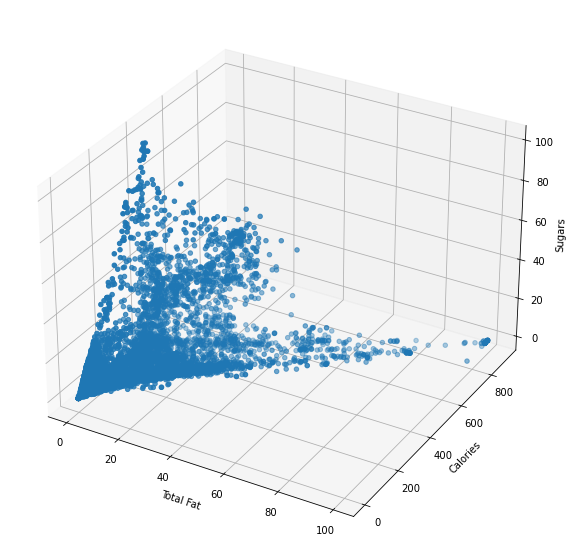

In [5]:
warnings.filterwarnings("ignore")
# Plot 3d scatter plot with 3 of the previous pre-selected features (e.g., total_fat, calories, sugars)
fig = plt.figure(figsize=(13,10)).gca(projection = "3d")
fig.scatter(df_clust["total_fat"], df_clust["calories"], df_clust["sugars"])
fig.set_xlabel("Total Fat")
fig.set_ylabel("Calories")
fig.set_zlabel("Sugars")
plt.show()

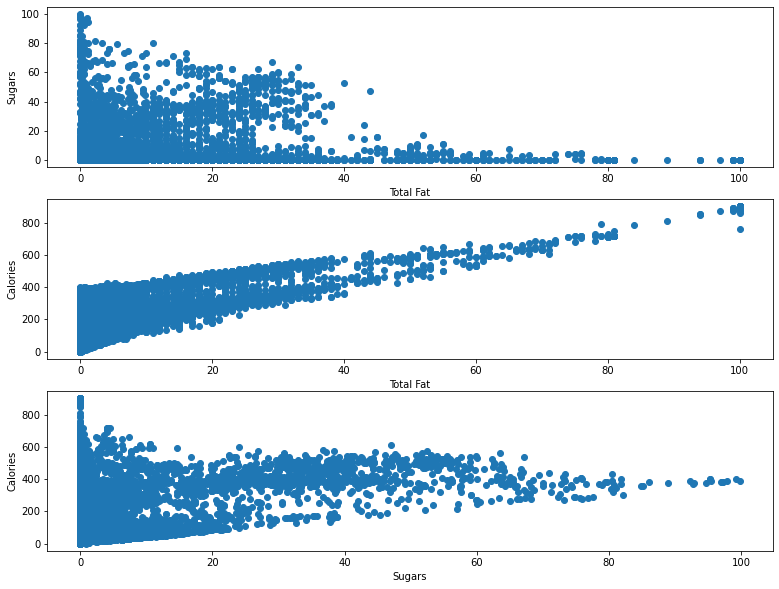

In [6]:
# As a visual reference, create the 2d subplots from each pair of the previous labels.
#fig = plt.figure(figsize=(25,20))
fig, axs = plt.subplots(3,figsize=(13, 10))

axs[0].scatter(x=df_clust["total_fat"], y=df_clust["sugars"], marker="o")
axs[0].set_xlabel("Total Fat")
axs[0].set_ylabel("Sugars")

axs[1].scatter(x=df_clust["total_fat"], y=df_clust["calories"], marker="o")
axs[1].set_xlabel("Total Fat")
axs[1].set_ylabel("Calories")

axs[2].scatter(x=df_clust["sugars"], y=df_clust["calories"], marker="o")
axs[2].set_xlabel("Sugars")
axs[2].set_ylabel("Calories")

plt.show()

In [7]:
# IMPORTANT: Before applying any clustering algorithm, normalizing the variables/features is required.
# For instance, calories and sugars scales are completely different. It might incur in future issues.

scaler = StandardScaler()
X = df_clust

scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

# Let's show the usual statistical features of each variable to ensure the normalisation.
scaled_df.describe()

# See that the dataframe is normalised since they all have std = 1.

calories     total_fat   cholesterol        sodium  carbohydrate  \
count  8.789000e+03  8.789000e+03  8.789000e+03  8.789000e+03  8.789000e+03   
mean  -7.404855e-17 -7.015791e-17  3.387601e-15  5.043816e-16 -2.887540e-15   
std    1.000057e+00  1.000057e+00  1.000057e+00  1.000057e+00  1.000057e+00   
min   -1.332239e+00 -6.674226e-01 -3.299729e-01 -3.261974e-01 -8.113754e-01   
25%   -7.964793e-01 -6.042009e-01 -3.299729e-01 -2.878656e-01 -8.095415e-01   
50%   -2.077327e-01 -3.449918e-01 -3.129302e-01 -2.367564e-01 -4.688080e-01   
75%    6.518375e-01  2.176816e-01  2.239150e-01  9.545283e-02  4.690343e-01   
max    3.978256e+00  5.654750e+00  2.608622e+01  4.094229e+01  2.856369e+00   

            glucose        sugars  saturated_fatty_acids  \
count  8.789000e+03  8.789000e+03           8.789000e+03   
mean  -3.087858e-15 -2.251205e-15          -9.321124e-17   
std    1.000057e+00  1.000057e+00           1.000057e+00   
min   -1.706587e-01 -4.925090e-01          -5.343960e-01   
25%   -1.706587e-01 -4.925090e-01          -5.112097e-01   
50%   -1.706587e-01 -4.567898e-01          -3.110921e-01   
75%   -1.706587e-01 -5.148618e-02           1.151304e-01   
max    3.332451e+01  6.782546e+00           1.434216e+01   

       monounsaturated_fatty_acids  polyunsaturated_fatty_acids  \
count                 8.789000e+03                 8.789000e+03   
mean                 -4.508852e-16                 6.913598e-16   
std                   1.000057e+00                 1.000057e+00   
min                  -5.526513e-01                -4.186998e-01   
25%                  -5.418101e-01                -3.921638e-01   
50%                  -3.182481e-01                -3.016644e-01   
75%                   1.446982e-01                -4.640469e-02   
max                   1.170795e+01                 1.435884e+01   

       fatty_acids_total_trans         water  
count             8.789000e+03  8.789000e+03  
mean              3.387601e-15  4.783218e-16  
std               1.000057e+00  1.000057e+00  
min              -3.299729e-01 -1.758527e+00  
25%              -3.299729e-01 -7.933404e-01  
50%              -3.129302e-01  2.914385e-01  
75%               2.239150e-01  7.750068e-01  
max               2.608622e+01  1.491260e+00

In [8]:
# Hierarchical Clustering: Dendogram
# No previous expectation of potential number of clusters

# Function taken from O'Reilly interactive Lab by Tobias Zwingmann
def dendogram_plot(md, **kwargs):
    count = np.zeros(md.children_.shape[0])
    n_samples = len(md.labels_)
    for (i, merge) in enumerate(md.children_):
        count_sum = 0
        for child_idx in merge:
            if child_idx < n_samples:
                count_sum += 1
            else:
                count_sum += count[child_idx - n_samples]
        count[i] = count_sum
    linkage_matrix = np.column_stack([md.children_,md.distances_,count]).astype(float)
    # Plot dendogram
    dendrogram(linkage_matrix, **kwargs)

X = scaled_df

# Model definition by using Agglomerative Clustering from sklearn. 
# No references of the desired number of clusters.
md = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Finally, let's create a dendogram by fitting our reduced dataframe.
clustered_model = md.fit(X)

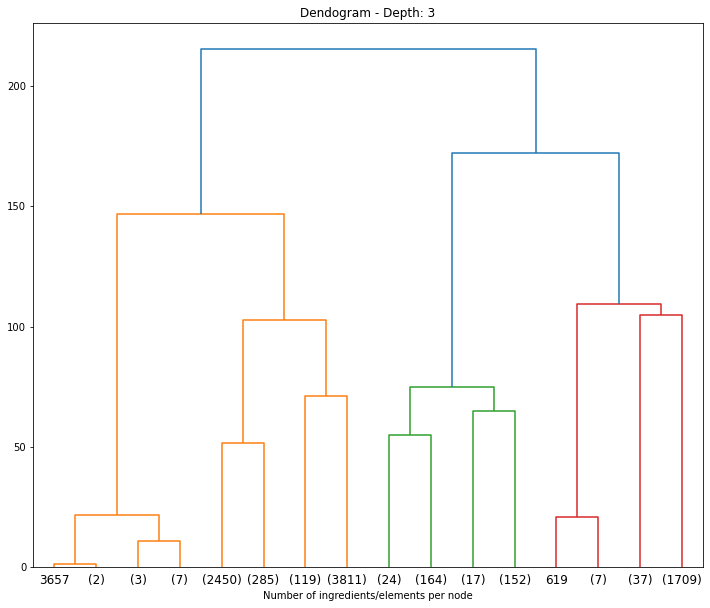

In [9]:
# Representation of the fitted dendrogram
fig = plt.figure(figsize=(12,10))
plt.title("Dendogram - Depth: 3")
dendogram_plot(clustered_model, truncate_mode ='level', p=3)
plt.xlabel("Number of ingredients/elements per node")
plt.savefig('Clustering_Dendogram.png')
plt.show()

# COMMENT: In the dendrogram, numbers that are not in parentesis represent single values. This means, the id number of that observation.

In [10]:
# QUESTION: Where do we cut the dendogram so we get the clusters with the highest separation among them? 
# If we separate out data in 4 clusters (i.e,. approx. height of 125), we obtain the following number of observations per cluster:
#   Cluster 1 (yellow-left): 13
#   Cluster 2 (yellow-right): 6665
#   Cluster 3 (blue-left): 357
#   Cluster 4 (blue-right): 1754

# However, this segmentation would not be descriptive enough since most of our observations would be added to Cluster 2. 
# Therefore, let's choose a more accurate number of clusters: 7 (height 80)
#   Cluster 1 (yellow-left): 13
#   Cluster 2 (yellow-center): 2737
#   Cluster 3 (yellow-right): 3930
#   Cluster 4 (blue-left): 357
#   Cluster 5 (red-left): 8
#   Cluster 6 (red-center): 37
#   Cluster 7 (red-right): 1709

# Thus, we are trying to maximize distances among clusters and disparity.

In [11]:
# Set a specific number of clusters based on a distance_threshold
data_fitting = AgglomerativeClustering(distance_threshold=90,n_clusters=None).fit(scaled_df)

# The unique count for each cluster is:
np.unique(data_fitting.labels_,return_counts=True)

# Matches our expectations.

(array([0, 1, 2, 3, 4, 5, 6]),
 array([1709, 3930,  357,   13,    8,   37, 2735]))

In [12]:
# For later use, we will add the cluster label to each ingredient in the non-normalized dataframes.
df_clust['Cluster num.'] = data_fitting.labels_.astype(str)
df2['Cluster num.'] = data_fitting.labels_.astype(str)

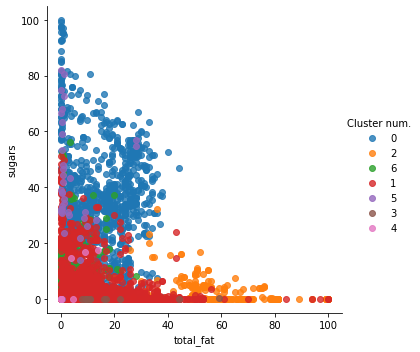

In [13]:
# Let's replot the previous scatter plots showing the our new clusters.
sns.lmplot(x = 'total_fat', y='sugars', data=df_clust, hue='Cluster num.', fit_reg=False)
plt.show()

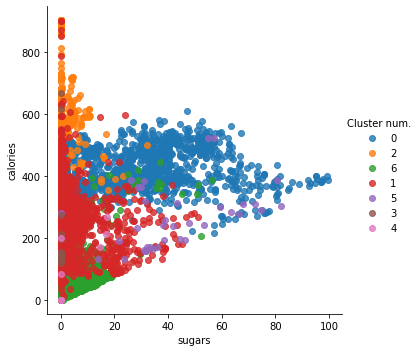

In [14]:
# Same between sugars and calories
sns.lmplot(x = 'sugars', y='calories', data=df_clust, hue='Cluster num.', fit_reg=False)
plt.show()

In [15]:
# Finally, we will assign the mean saturated_fat value from each cluster to the ingredients with non-defined value (NaN)
# NOTE: Pandas excludes NaN values when creating the mean.

mean_satFat = df2.groupby('Cluster num.')['saturated_fat'].mean()
mean_satFat

Cluster num.
0     4.362579
1     4.089225
2    18.600280
3     4.815385
4     2.725000
5     2.311111
6     0.767811
Name: saturated_fat, dtype: float64

In [16]:
df2["saturated_fat"] = np.where(pd.isna(df2["saturated_fat"]), mean_satFat[df2["Cluster num."]], df2["saturated_fat"])

df2.head(10)

name  serving_size  calories  total_fat  saturated_fat  \
0          Cornstarch         100.0     381.0        0.1       4.362579   
1        Nuts, pecans         100.0     691.0       72.0       6.200000   
2       Eggplant, raw         100.0      25.0        0.2       0.767811   
3      Teff, uncooked         100.0     367.0        2.4       0.400000   
4     Sherbet, orange         100.0     144.0        2.0       1.200000   
5    Cauliflower, raw         100.0      25.0        0.3       0.100000   
6    Taro leaves, raw         100.0      42.0        0.7       0.200000   
7   Lamb, raw, ground         100.0     282.0       23.0      10.000000   
8   Cheese, camembert         100.0     300.0       24.0      15.000000   
9  Vegetarian fillets         100.0     290.0       18.0       2.800000   

   cholesterol  sodium  choline  folate  folic_acid  ...  \
0          0.0     9.0      0.4     0.0         0.0  ...   
1          0.0     0.0     40.5    22.0         0.0  ...   
2          0.0     2.0      6.9    22.0         0.0  ...   
3          0.0    12.0     13.1     0.0         0.0  ...   
4          1.0    46.0      7.7     4.0         0.0  ...   
5          0.0    30.0     44.3    57.0         0.0  ...   
6          0.0     3.0     12.8   126.0         0.0  ...   
7         73.0    59.0     69.3    18.0         0.0  ...   
8         72.0   842.0     15.4    62.0         0.0  ...   
9          0.0   490.0     82.0   102.0         0.0  ...   

   saturated_fatty_acids  monounsaturated_fatty_acids  \
0                  0.009                        0.016   
1                  6.180                       40.801   
2                  0.034                        0.016   
3                  0.449                        0.589   
4                  1.160                        0.530   
5                  0.130                        0.034   
6                  0.151                        0.060   
7                 10.190                        9.600   
8                 15.259                        7.023   
9                  2.849                        4.376   

   polyunsaturated_fatty_acids  fatty_acids_total_trans  alcohol   ash  \
0                        0.025                      0.0      0.0  0.09   
1                       21.614                      0.0      0.0  1.49   
2                        0.076                      0.0      0.0  0.66   
3                        1.071                      0.0      0.0  2.37   
4                        0.080                      1.0      0.0  0.40   
5                        0.031                      0.0      0.0  0.76   
6                        0.307                      0.0      0.0  1.92   
7                        1.850                     73.0      0.0  0.87   
8                        0.724                     72.0      0.0  3.68   
9                        9.332                      0.0      0.0  5.00   

   caffeine  theobromine  water  Cluster num.  
0       0.0          0.0   8.32             0  
1       0.0          0.0   3.52             2  
2       0.0          0.0  92.30             6  
3       0.0          0.0   8.82             0  
4       0.0          0.0  66.10             1  
5       0.0          0.0  92.07             6  
6       0.0          0.0  85.66             6  
7       0.0          0.0  59.47             1  
8       0.0          0.0  51.80             1  
9       0.0          0.0  45.00             1  

[10 rows x 77 columns]

In [17]:
# Drop cluster number column
df = df2.drop(columns=["Cluster num."])
df.head(5)
# Save new dataframe
df.to_csv("cleaned_data.csv")

<font color='darkblue'> <u>**Preprocessing Discussion:**</u> At the end, 7 clusters of aliments were obtained based on the Hierarchical clustering algorithm. The mean of the saturated fats for each subgroup was computed and added to the value of those aliments that had a missing value in the 'saturated fats' feature. We mainly distinguish one group (n=357) that had a high percentage of saturated fats (18.6g) compared to the group with foods with less saturated fats (0.76g) (n=2735).

### <font color='green'> 2.2 _Data Normalization:_
    
Once we have dealt with the missing values, we decided to normalize the values of the dataset between the range (0,1), thus scaling the maximum value of each feature to 1 and the minimum one to 0, as shown below. 


In [18]:
df=pd.read_csv('data/cleaned_data.csv',index_col=0)
df=df.set_index('name')

# copy the data
df_notnorm=df.copy()
df_norm = df.copy()
  
# apply normalization techniques
for column in df_norm.columns:
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())    
    
df_norm.head()

calories  total_fat  saturated_fat  cholesterol    sodium  \
name                                                                         
Cornstarch       0.422395      0.001       0.044448     0.000000  0.000232   
Nuts, pecans     0.766075      0.720       0.063608     0.000000  0.000000   
Eggplant, raw    0.027716      0.002       0.006964     0.000000  0.000052   
Teff, uncooked   0.406874      0.024       0.003128     0.000000  0.000310   
Sherbet, orange  0.159645      0.020       0.011470     0.000323  0.001187   

                  choline    folate  folic_acid    niacin  pantothenic_acid  \
name                                                                          
Cornstarch       0.000166  0.000000         0.0  0.000000          0.000000   
Nuts, pecans     0.016852  0.005811         0.0  0.009153          0.025014   
Eggplant, raw    0.002871  0.005811         0.0  0.005090          0.008145   
Teff, uncooked   0.005451  0.000000         0.0  0.026376          0.027304   
Sherbet, orange  0.003204  0.001057         0.0  0.000494          0.006493   

                 ...     fat  saturated_fatty_acids  \
name             ...                                  
Cornstarch       ...  0.0005               0.000094   
Nuts, pecans     ...  0.7197               0.064644   
Eggplant, raw    ...  0.0018               0.000356   
Teff, uncooked   ...  0.0238               0.004697   
Sherbet, orange  ...  0.0200               0.012134   

                 monounsaturated_fatty_acids  polyunsaturated_fatty_acids  \
name                                                                        
Cornstarch                          0.000191                     0.000335   
Nuts, pecans                        0.487531                     0.289643   
Eggplant, raw                       0.000191                     0.001018   
Teff, uncooked                      0.007038                     0.014352   
Sherbet, orange                     0.006333                     0.001072   

                 fatty_acids_total_trans  alcohol       ash  caffeine  \
name                                                                    
Cornstarch                      0.000000      0.0  0.000902       0.0   
Nuts, pecans                    0.000000      0.0  0.014930       0.0   
Eggplant, raw                   0.000000      0.0  0.006613       0.0   
Teff, uncooked                  0.000000      0.0  0.023747       0.0   
Sherbet, orange                 0.000323      0.0  0.004008       0.0   

                 theobromine   water  
name                                  
Cornstarch               0.0  0.0832  
Nuts, pecans             0.0  0.0352  
Eggplant, raw            0.0  0.9230  
Teff, uncooked           0.0  0.0882  
Sherbet, orange          0.0  0.6610  

[5 rows x 74 columns]

## <font color='darkgreen'> 3. Creation of the Network

#### <center> How are the aliments and nutrients connected with each other? </center>
With the dataset prepared, it's time to build our nutritional graphs and its interactions by using the python library `NetworkX`. We started by adding two different types of nodes to the graph: 
1. The **nurtients**: They correspond to the columns of the Panda Dataframe.  
2. The **aliments**: They correspond to each observation of our dataset.  

Then, a criteria to add edges to the network was defined. For each feature of the dataframe, we sorted the observations in a descending order (from high to low values) and the first 15% observations, corresponding to the aliments with the highest amount of that feature (n=1318), were used to create a link between the aliment and the nurtient. In that way, we just allow links between nutrient node and aliment node. Moreover, the edges added to the network are weighted to keep and capture the importance of the nutrient in each specific aliment based on previous normalization.
    
As shown below, the resultant network was defined with **8863** nodes and **97532** edges.
Next, to reduce the network dimensionaly, all nodes with a degree equals 0 were removed from the network, ending up with a network of **8720** nodes where the connections state the importance of nutrients in each aliment.
    

In [19]:
#NetworkX Graph to store the network
percentage=0.15
criteria=int(percentage*8789)

df=df_norm.copy()

F= nx.Graph()
for el in list(df):
    F.add_node(el,Role='Feature')
for el in df.index:
    F.add_node(el,Role='Aliment')
    
print("There are " +str(F.number_of_nodes())+" nodes in our network.")


for f in df.columns:
    sorted_df=df.sort_values(by=[f],ascending=False).iloc[:criteria,0]
    for idx,el in enumerate(sorted_df.index):
        F.add_weighted_edges_from([(f,el,sorted_df[idx])])

There are 8863 nodes in our network.


In [20]:
print("There are " +str(F.number_of_edges())+" edges in our network.")

There are 97532 edges in our network.


In [21]:
nodes_d0 = [node for node,degree in dict(F.degree()).items() if degree == 0]
print(len(nodes_d0))

143


In [22]:
sF=F.copy()
sF.remove_nodes_from(nodes_d0)

In [23]:
print('Number of nodes:',sF.number_of_nodes())
print('NUmber of edges:',sF.number_of_edges())

Number of nodes: 8720
NUmber of edges: 97532


### <font color='green'> 3.1 _Visualize the Network:_

With the current version of the Network of aliments and nutrients, it is now time to visualize it. We have specified some visualization options: the node size for 'aliments' was determined by its degree and node positions were obtained based on the "Force Atlas 2 algorithm".
   

In [24]:
color_map=[]
degree=[]
for node in F.nodes:
    if F.nodes[node]['Role']=='Feature':
        color_map.append('#157B87')
        degree.append(300)
    else:
        color_map.append('#9B149A')
        degree.append(F.degree(node))

In [25]:
positions = force_atlas2_layout(F,
                                iterations=60,
                                pos_list=None,
                                node_masses=None,
                                outbound_attraction_distribution=False,
                                lin_log_mode=False,
                                prevent_overlapping=False,
                                edge_weight_influence=2.0,

                                jitter_tolerance=1.0,
                                barnes_hut_optimize=True,
                                barnes_hut_theta=1.2,

                                scaling_ratio=0.1,
                                strong_gravity_mode=False,
                                multithread=False,
                                gravity=10.0)

options={
    'node_color':color_map,
    'node_size':degree,
    'width':0.4,
    'alpha':0.9
}

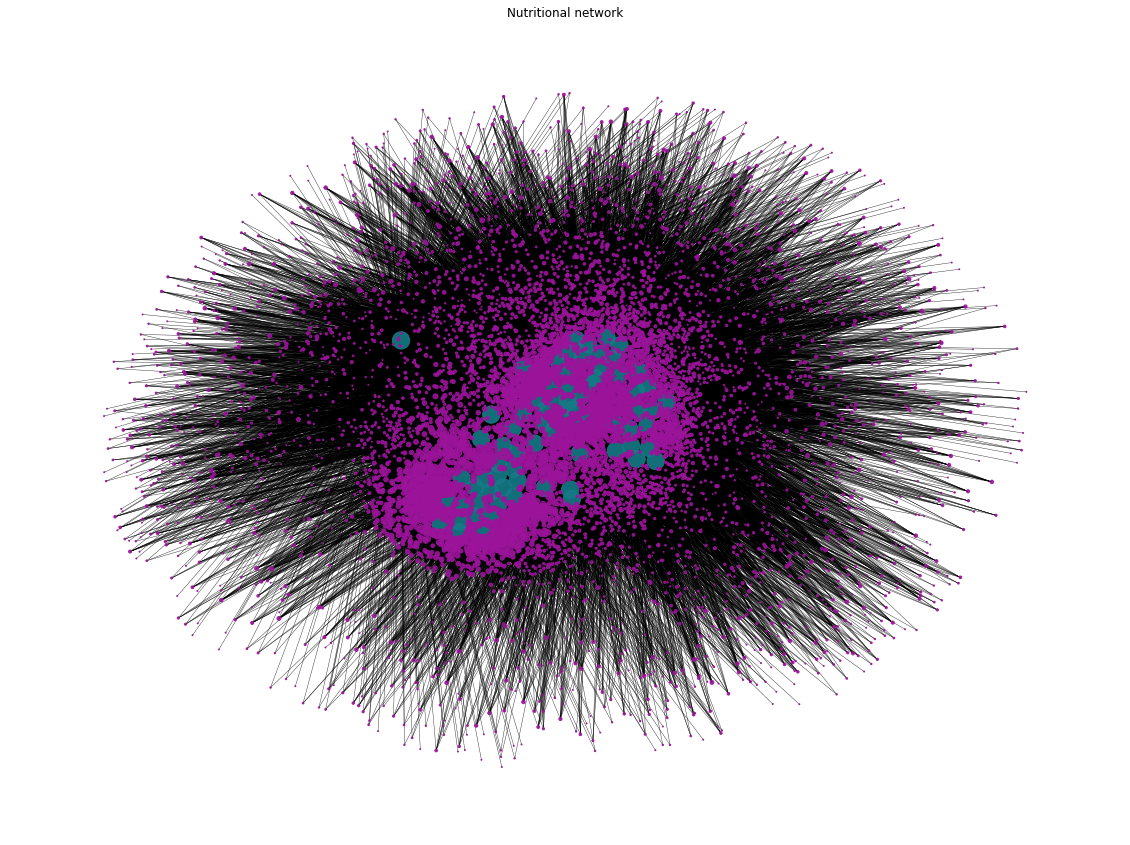

In [26]:
plt.figure(figsize=(30, 15))
plt.title('Nutritional network')
fig = plt.gcf()
nx.draw(F, positions, **options)

fig.set_size_inches(20, 15)
plt.savefig('network')

<font color='darkblue'> <u>**Network Discussions:**</u> Above, we can see the version of our Nutritional Network, with a total number of 8720 nodes, representing nutrients (in blue) and aliments (in purple), and 97532 undirected weighted edges, representing the influence and the amount of nutients in each aliment. 
Overall, we cannot clearly draw conclusions of the network due to the large ammount of nodes and links, alhough the  size of purple nodes (the aliments), could indicate if that aliment is rich in more or less nutrients. 
   

### <font color='green'> 3.2 _Statistical Analysis of the Network:_
With the network in mind, we can further analyize the intrinsic characterstics of our network, such as the degree distribution. 
    
- **Degree Distributions:** This basic stats of the network was computed, together with the average degree of the aliment nodes. In this case, the nutrient nodes were exluced from this analysis since all of them have the same amount of links (edges= 1308). 
    
    



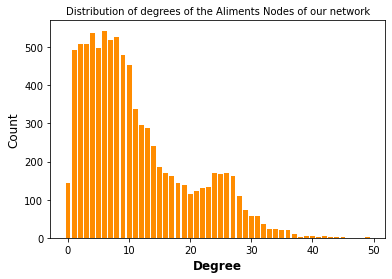

In [27]:
hist_dist={}
nodesA = [x for x,y in F.nodes(data=True) if y['Role']=='Aliment']
for ali in nodesA:
    hist_dist[ali]=F.degree[ali]
    
count1,bins1=np.histogram(list(hist_dist.values()),bins=np.arange(0,51))
plt.bar(bins1[:-1], count1,color='darkorange')
plt.title('Distribution of degrees of the Aliments Nodes of our network',fontsize=10)
plt.xlabel('Degree',fontsize=12,fontweight='bold')
plt.ylabel('Count',fontsize=12)
plt.savefig('Histogram')
plt.show()

In [28]:
print('The average degree of the aliment nodes',np.round(np.mean(list(hist_dist.values())),3))

The average degree of the aliment nodes 11.097


<font color='darkblue'> <u>**Degree Distribution Discussion:**</u> The degree distribution histogram shows how the many edges have the aliment nodes in our built network, that is to say, the degree of that node. We observed that the average degree of the aliment node is of 11, thus each aliment is rich in approximately 11 nutrients/features. However, we observed nodes with a low degree, which may correspond to aliments not rich in a lot of nutients and nodes with high degrees, being aliments rich in many feautres. 
To get more insight into this, the aliments present in these two groups are shown below. 

- **Aliments rich in many nutrients:** 

In [29]:
sorted_hist = sorted(hist_dist.items(), key=lambda x: x[1], reverse=True)
for i in range(1,11):
    print(i,'-',sorted_hist[i][0],'is rich in',sorted_hist[i][1],'features.')

1 - Egg, dried, yolk is rich in 49 features.
2 - Egg Mix, USDA Commodity is rich in 45 features.
3 - Spices, dried, parsley is rich in 45 features.
4 - Beef, pan-fried, cooked, liver, variety meats and by-products is rich in 44 features.
5 - Beef, braised, cooked, liver, variety meats and by-products is rich in 44 features.
6 - Egg, glucose reduced, stabilized, dried, whole is rich in 43 features.
7 - Veal, pan-fried, cooked, liver, variety meats and by-products is rich in 43 features.
8 - Seeds, without salt, roasted, pumpkin and squash seed kernels is rich in 43 features.
9 - Spices, ground, mustard seed is rich in 42 features.
10 - Seeds, dried, pumpkin and squash seed kernels is rich in 42 features.


- **Aliments not rich in a lot of nutients:** 

In [30]:
aliments_0=0
for k,v in hist_dist.items():
    if v==0:
        aliments_0+=1
print('There are',aliments_0,'with 0 edges.')

There are 143 with 0 edges.


<font color='darkblue'> <u>**Discussion:**</u> We observed that 143 aliments have no edges, that means that they are not connected to the network and can be removed. These aliments are the ones that they don't stand out by being rich in at least one nutrient. On the other hand, we observed several aliments with a degree of around 45, turing out to be the ones rich with several nutrients in proportion to the rest of our observations. 
    


### <font color='green'> 3.3 _Finding Communities:_
    
Our next aim was to find communities inside the created network by comparing different algorithms and be able to analyse the group of aliments and features in each subgroup. First of all, based on the **Girwan Newman algorithm** seen in Week 8 of the course, a function was created to iteratively eliminate the edges that have the highest number of shortest paths between nodes passing through them. Thus, by removing these  edges from the graph one-by-one, the network could break down into smaller pieces, so-called communities. 

However, using this algorithm to extract communites for our network turns out to be really expensive computationally due to the high number nodes and edges. In that way, we decided to use another algorithms to find comnunities within our network. Nevertheless, to still show the functionally of the Girwan Newman algorithm, a subgraph of our network was created to remove the edges with the the highest centrality as shown in the example below. We observed that the number of nodes were mantained (n=66 nodes) but the number of edges was reduced.    

**Using Girvan Newman Algorithm:**

In [31]:
def Girvan_Newman(G,num_communities=6):
    communities=1
    while communities<num_communities:
        d_s=nx.shortest_path(G)
        s=[]
        for i in d_s.values():
            for j in i.values():
                if len(j)>1:
                    s.append(j)
        edges=[]
        for el in s:
            if len(el)>2:
                l=len(el);c=0
                while c<l-1:
                    edges.append(str(el[c:c+2]));c+=1
            else:
                edges.append(str(el))
        counts=Counter(edges)
        d={}
        for el in list(G.edges()):
            idx=str(list(el))
            d[el]=counts[idx]

        # Remove edge with highest centrality
        idx_max=list(d.values()).index(max(d.values()))
        max_edge=list(d.keys())[idx_max]
        G.remove_edges_from([max_edge])
        communities+=1
    return G

Initial subgraph with 66 nodes and 188 edges.


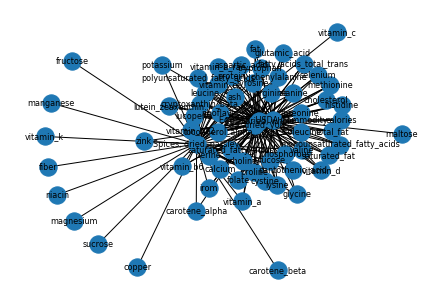

In [32]:
#Using a subgraph to apply the handed-coded Girwan_Newman
sub_graph=sF.copy()
remove = [node for node,degree in dict(sub_graph.degree()).items() if degree <45]
sub_graph.remove_nodes_from(remove)
remove2 = [node for node,degree in dict(sub_graph.degree()).items() if degree ==0]
sub_graph.remove_nodes_from(remove2)
print('Initial subgraph with',len(sub_graph.nodes()),'nodes and',len(sub_graph.edges()),'edges.')

nx.draw(sub_graph, with_labels=True,font_size=8)

New graph using Girvan_Newman Alorithm Graph with 66 nodes and 183 edges .


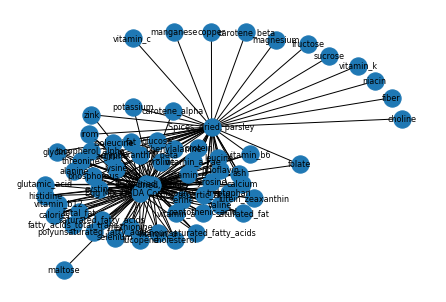

In [33]:
P=Girvan_Newman(sub_graph)
print('New graph using Girvan_Newman Alorithm',P,'.')
nx.draw(P, with_labels=True,font_size=8)

**Using the Louvain heuristices, maximizing modularity:**

Due to the computational costs of the Girwan Newman algorithm to extract communities, we searched other types of alogrithms we could use that are computationally faster. We ended by finding that the **Louvain algorithm** could be a good candidate to detect communities based on the partition of the highest modularity. The algorithm computes then the partition of the graph nodes which maximises the modularity value.

In [35]:
partition = community.community_louvain.best_partition(sF)
print('Number of communities found: ', len(np.unique(list(partition.values()))))
mod = community.community_louvain.modularity(partition, sF)
print("The modularity value is:","{:.3f}".format(mod))

Number of communities found:  43
The modularity value is: 0.380


We have finally found **43** communities, with a modularity value of **0.380**, which might state that there is not a random division of the network and some kind of clusters are present. 

Next, we compute the number of nodes present in each of these communities.

#### <font color='green'> 3.3.1 _Analysis of the Communities:_
 
By analyzing each community, we found out that most of the communities have just one aliment, reason why it was decided to remove these nodes for the following analyses, having at the end 4 representative clusters of aliments and nurtients.

In [36]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

In [37]:
#Delete the communities that have just one node:
v=list(partition.values())
p=partition
a_remove=[]
for i in (list(range(0,len(np.unique(list(partition.values())))))):
    x=list(partition.values()).count(i) 
    if x==1:
        v.remove(i)
        a=get_keys_from_value(p, i)
        a_remove.append(a[0])
        del p[a[0]]
        
        
communities_d=dict.fromkeys(list(range(0,len(np.unique(v)))))

In [38]:
sF2=sF.copy()
sF2.remove_nodes_from(a_remove)

In [39]:
# We compute the number of songs in every community
for i in range(0,len(np.unique(v))):
    l=[]
    for el in partition:
        if partition[el]==list(np.unique(v))[i]:
            l.append(el)
    communities_d[i]=l
    
size_communities=[len(x) for x in communities_d.values()]
for ind,j in enumerate(size_communities):
     print('Community',ind,'with:',j,'nodes.')

Community 0 with: 1673 nodes.
Community 1 with: 1971 nodes.
Community 2 with: 2478 nodes.
Community 3 with: 2559 nodes.


In [40]:
#Delete the communities that have just one node to plot histogram:
sub_communities_v=[]

for i in range(0,len(size_communities)):
    sub_communities_v=sub_communities_v+[i]*size_communities[i]

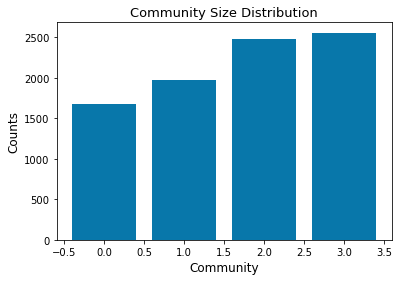

In [41]:
count,bins= np.histogram(sub_communities_v,bins=[0,1,2,3,4])
plt.bar(bins[:-1], count,color='#0877aa');plt.title('Community Size Distribution',fontsize=13)
plt.xlabel('Community',fontsize=12); plt.ylabel('Counts',fontsize=12)
plt.savefig('size_distribution')
plt.show()

<font color='darkblue'> <u>**Plot Discussion:**</u> The plot shows the size of each community encountered in the nutritional network with more than 1000 nodes each. These groups would correpond to similar aliments in terms of nutrient proportion.

#### <font color='green'> 3.3.2 _Visualize Communities:_
    
From now one, every community is being named with the nurtient with highest degree. Thus, we can consider this nutrient as the central node of each community.
    
Once having the communities determined, we can now visualize them to see how they are distributed in our network. The "Force Atlas 2 algorithm" have been used again to determine node positions.

In [42]:
communities_named={}
for el in communities_d:
    degrees=[sF2.degree(node) for node in communities_d[el]]
    communities_named[communities_d[el][degrees.index(max(degrees))]]=communities_d[el]

for ind, j in enumerate(communities_named.keys()):
    print('Community',ind,'with',"\033[1m" + j + "\033[0m",'as the node with the maximum degree.')

Community 0 with calories as the node with the maximum degree.
Community 1 with cholesterol as the node with the maximum degree.
Community 2 with folate as the node with the maximum degree.
Community 3 with carotene_beta as the node with the maximum degree.


In [43]:
node_community = [node[1] for node in p.items()]
pCol = {i: list(np.random.random(size=3)) for i in set(node_community)}

In [44]:
positions = force_atlas2_layout(sF2,
                                iterations=100,
                                pos_list=None,
                                node_masses=None,
                                outbound_attraction_distribution=False,
                                lin_log_mode=False,
                                prevent_overlapping=False,
                                edge_weight_influence=2.0,

                                jitter_tolerance=1.0,
                                barnes_hut_optimize=True,
                                barnes_hut_theta=1.2,

                                scaling_ratio=0.1,
                                strong_gravity_mode=False,
                                multithread=False,
                                gravity=10.0)

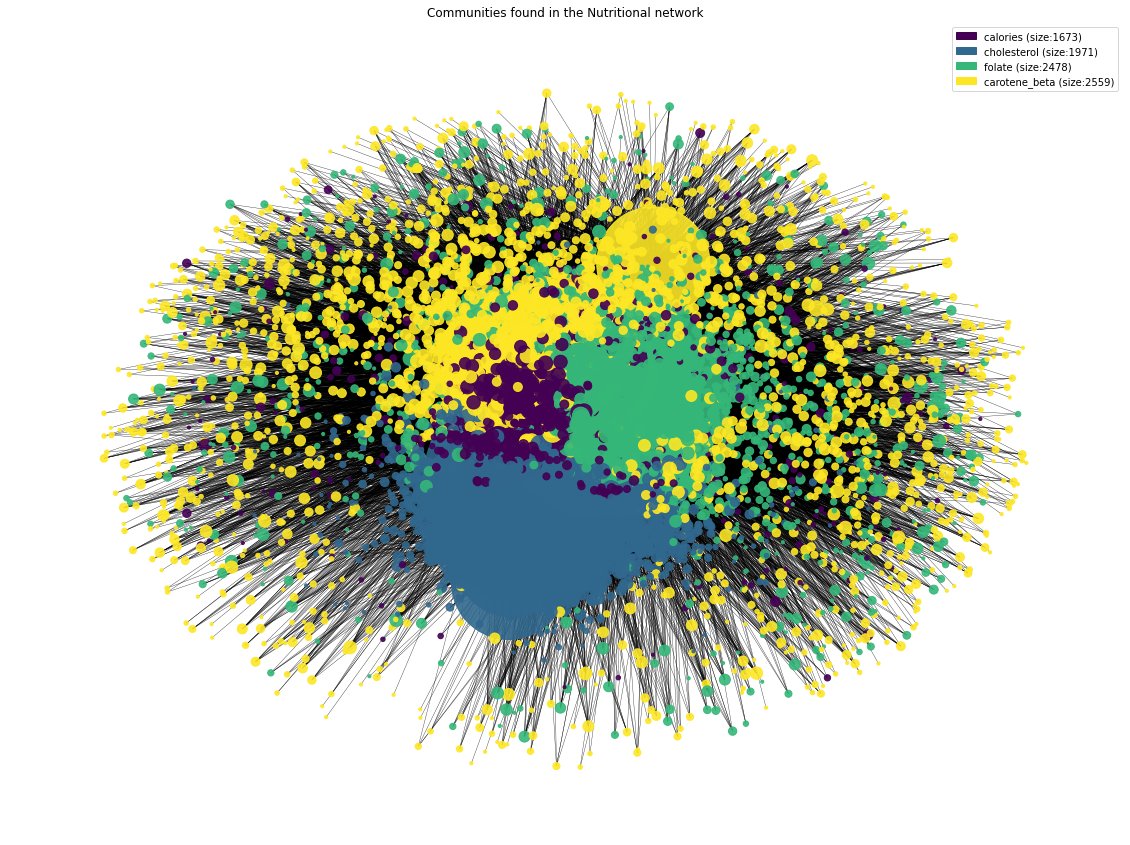

In [45]:
plt.figure(figsize=(30, 15))
f = dict(nx.degree(sF2))
node_sizes = [v*10 for v in f.values()]
plt.title('Communities found in the Nutritional network')
cmap = cm.get_cmap('viridis', len(np.unique(v)))
fig = plt.gcf()
nx.draw(sF2, positions, node_size=node_sizes, with_labels=False, width = 0.35, node_color=list(p.values()), alpha=0.9)
# add legend
legend=[]
for idx,el in enumerate(cmap.colors):
    legend.append(mpatches.Patch(color=cmap.colors[idx], label=list(communities_named.keys())[idx]+' (size:'+str(size_communities[idx])+')'))
plt.legend(handles=legend)
fig.set_size_inches(20, 15)
plt.savefig('communities_graph')

<font color='darkblue'> <u>**Community Visualization Discussion:**</u> From the undirected network above, we can distinguish the 4 communities in different colors, as presented in the plot legend.  The _"Force Atlas 2 algorithm"_ has managed to optimally locate nodes by community groups, but without showing a perfect delimitation or clusters due to the modularity value of 0.373. 

#### <font color='green'> 3.3.3 _Getting more insight into the existing communities: Generation of World Clouds per community_
    
We were also interested in generating **wordclouds for each community** of aliments and nurtients to better analyze each community. Based on the degree of each node, the aliment and node was added to a string as many times as its degree.
Then, all strings are stored in a dictionary, where the name of the community is the "key", and the strings the dictionary values.

In [46]:
#World Cloud to better define communities:
wordcloud_dict={}
for i in np.unique(v):
    a=get_keys_from_value(p, i)
    degree_a={}
    for node in a:
        degree_a[node]=sF2.degree(node)
        
    s_dict=dict(sorted(degree_a.items(), key=lambda item: item[1],reverse=True))
    text=[]
    for k,v in s_dict.items():
        text=text+[k]*v
    text_comm = ''
    for el in text:
        text_comm +=el+' '
    wordcloud_dict[i]= text_comm
    

In [47]:
#Title of the network
names=list(communities_named.keys())

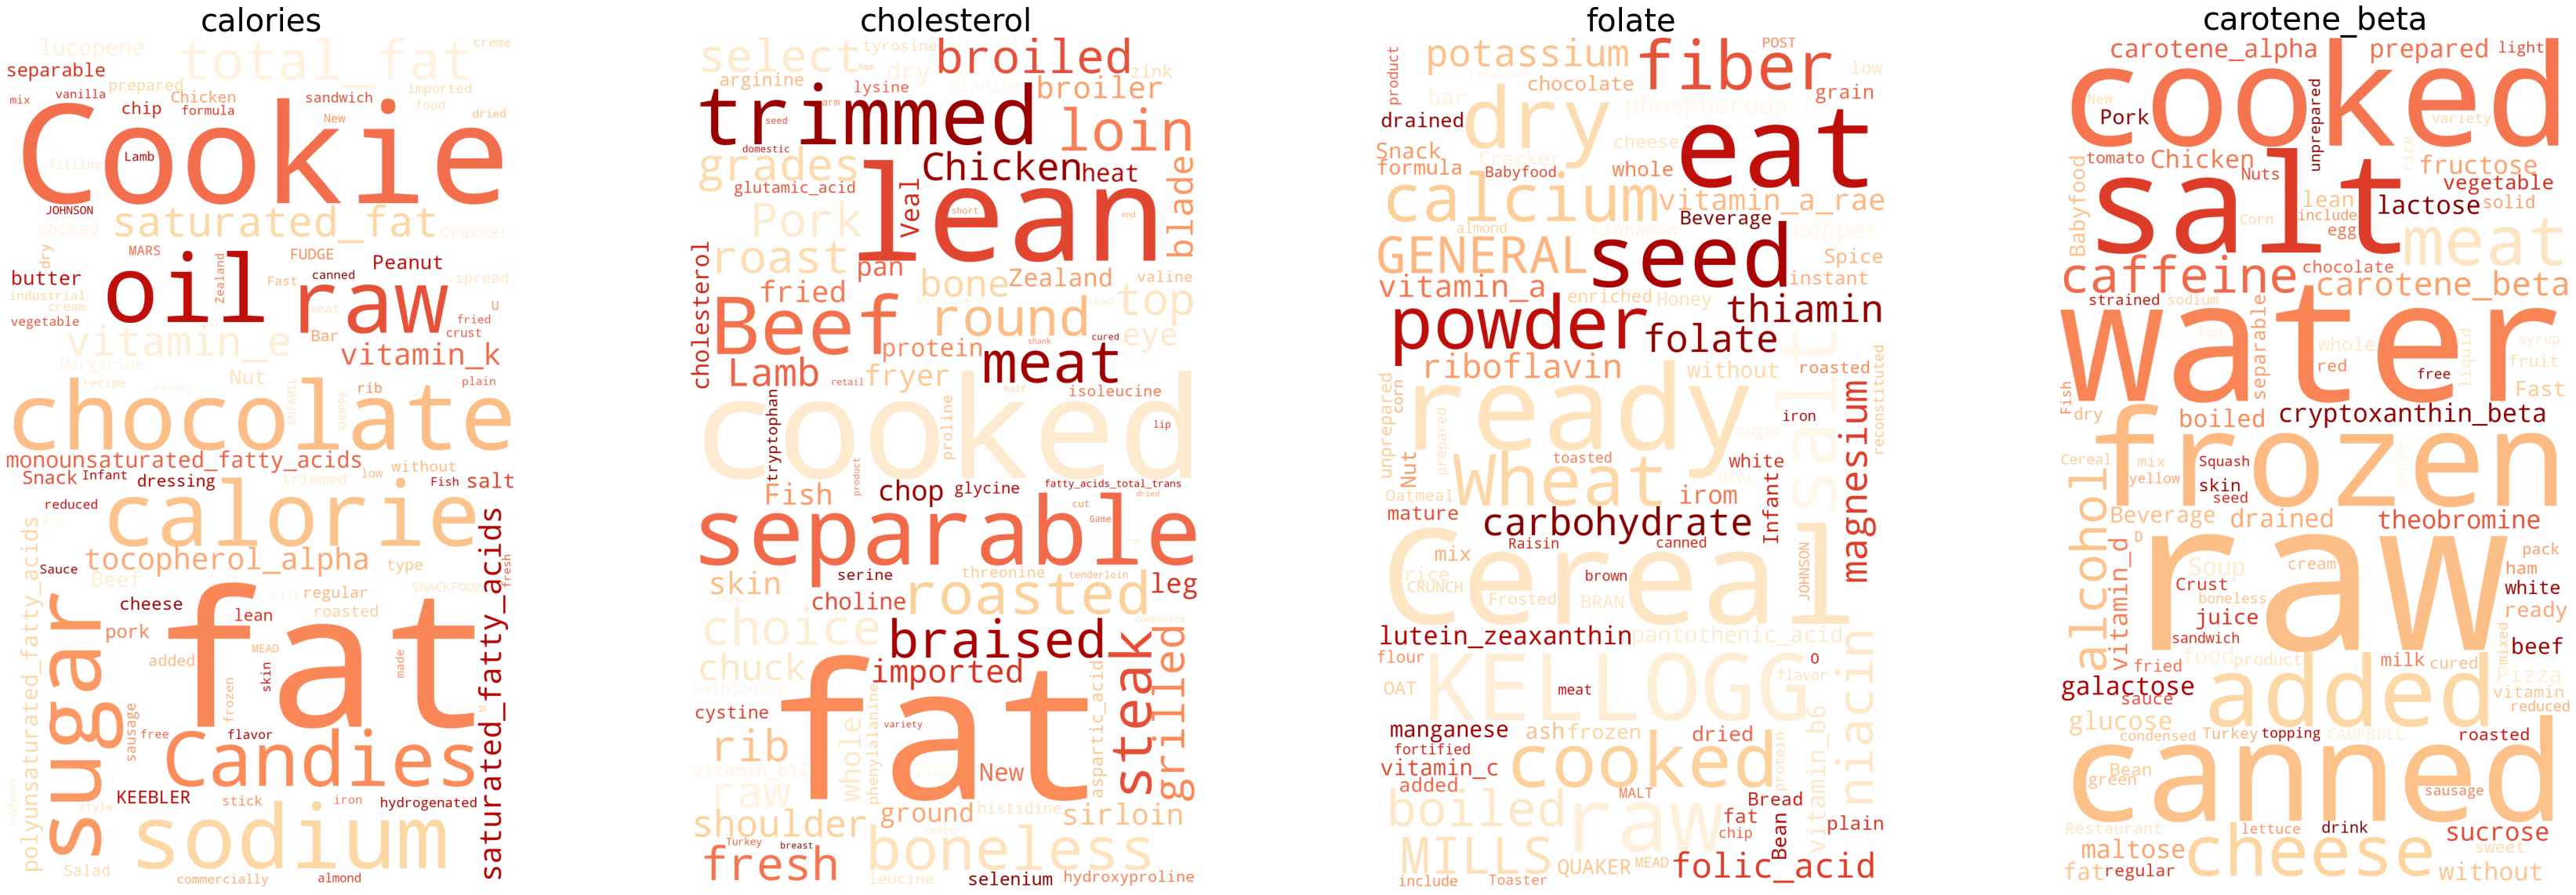

In [48]:
width = 1200; height = 2000
wordcloud_0 = WordCloud(colormap = cm.OrRd, max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict[list(wordcloud_dict.keys())[0]])
wordcloud_1 = WordCloud(colormap = cm.OrRd, max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict[list(wordcloud_dict.keys())[1]])
wordcloud_2 = WordCloud(colormap = cm.OrRd, max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict[list(wordcloud_dict.keys())[2]])
wordcloud_3 = WordCloud(colormap = cm.OrRd, max_words = 100, width=width, height=height, background_color = "white",
                         collocations = False).generate(wordcloud_dict[list(wordcloud_dict.keys())[3]])


fig, axs = plt.subplots(1, 4,figsize=(60,20))
axs[0].imshow(wordcloud_0); axs[0].set_title(names[0],size=40); axs[0].axis('off')
axs[1].imshow(wordcloud_1); axs[1].set_title(names[1],size=40); axs[1].axis('off')
axs[2].imshow(wordcloud_2); axs[2].set_title(names[2],size=40); axs[2].axis('off')
axs[3].imshow(wordcloud_3); axs[3].set_title(names[3],size=40); axs[3].axis('off')
plt.savefig('Communities')
plt.show()

<font color='darkblue'> <u>**WordCloud Discussion:**</u> 4 wordclouds, one for each community, were obtained based on the importance of each node in the community. Thus, words with larger sizes are then related to a higher degree in the network.  The title of each wordcloud represents the nutrient with the highest degree within the community. By looking each worldcloud, we can view many aliments and nutients related to the title of the community and between each other. 

#### <font color='green'> 3.3.4 _Spectral Clustering:_
Spectral Clustering resulted to be another algorithm to identify communities of nodes in a graph based on the edges connecting them. The idea here was to try to see if we could obtain a similar partition of our network based on having 4 communities. 

In [49]:
adj_matrix = nx.to_numpy_matrix(sF2) 
node_list = list(sF2.nodes())

#non-deterministic btw
clusters = SpectralClustering(affinity='precomputed', n_clusters=4).fit_predict(adj_matrix)

In [50]:
for i in np.unique(clusters):
    print('Cluster',i,'have',list(clusters).count(i),'elements.')

Cluster 0 have 811 elements.
Cluster 1 have 125 elements.
Cluster 2 have 321 elements.
Cluster 3 have 7424 elements.


## <font color='darkgreen'> 4. Recommendation Systems
    
Creating a network brings us the possibility to obtain certain applications beyond the descriptive ones shown above. Considering how the network has been created, we can interact between food nodes and feature nodes to offer a recommendation system. Multiple approaches and perspectives can be taken when considering on what the recommendations should be based on, and thus which features the system should offer.
In the scope of this project two different approaches have been implemented: a basic one that recommends aliments rich in the user input nutrient sorted by weight, and a more elaborated one that considering a certain aliment the user eats, recommends better substitutes. However, as we are dealing with a nutritional problem, limitations and considerations need to be carefully taken into account when analyzing the output that our recommendation system suggests. There are no absolute truths when it comes to nutrition and therefore the recommended substitutes will just apply on a certain detailed specified context.

The following recommendations were followed:
    
  
1. Recommend aliments rich in one nutrient based its neighbourdhood. This could solve the Lack of specific nutrients/features in your diet. 
2. Recommend better substitues of aliments one could eat based on the neighbourhood of its neighbourds.

  

### <font color='green'> 4.1 _Recommendation System based on lack of specific nutrients/features in your diet:_ 
#### <center> Recommend aliments rich in this nutrient.</center>

First application considers the scenario where in a specific diet is missing one nutrient and the user wants to look for food suggestions that are rich in this nutrient. Based on how the network is built, a function is created that takes all the aliments rich in that nutrient and sorts them based on the weight (higher weight implies higher content of that specific nutrient). User can also select how many suggestions wants to obtain.

In [ ]:
def provide_aliments_rich_in_one_feature(feature,number_of_elements=10):
    d={}
    for el in F.edges(feature,data=True):
        d[el[1]]=el[2]['weight']
    features=list(d.keys())
    return features[0:number_of_elements]

provide_aliments_rich_in_one_feature('sodium')

### <font color='green'> 4.2 _Recommendation System for better food substitutes based on neighbourhood:_ 

The main challenge comes from this second application. The aim here is to suggest better food substitutes while avoiding inconsistencies that contradict nutrition basic principles. Thus, the concept better has been defined here in the following way: "We will affirm that an aliment is better than another if is rich in the same features/nutrients but is still rich in extra ones". Let us say, when looking for a substitute of 'Fat, mutton tallow' which is rich in 13 features, the system will output 'Egg, dried, yolk' and 'Egg, dried, whole', which are rich in the 13 features present in 'Fat, mutton tallow' but are also rich in other 36 features.

The suggested scenario seems to be reasonable when in comes to micronutrients (micros) however has certain limitations when considering macronutrients (macros). In the example shown above, it is shown how egg is clearly the best alternative, but substituting the mutton tallow fat for egg would imply a severe imbalance in fats and protein intake. Thus, an extra filter has been implemented, allowing the user to choose whether to consider macros or not when looking for better substitutes, and if so, until which percentage of change in macros levels is accepted.

The algorithm implemented, `provide_better_substitutes()` is described below:

Given a `food A`, rich in these features \[`feature A`, `feature B`, `feature C`\] (sorted by weight)

neigh = \[Find foods attached to `feature A`\] => \[`food B`,`food C`,`food D`,`food E`\] 

For el in neigh:
- food B : \[`feature D`, `feature A`, `feature E`\]
- food C : \[`feature F`, `feature B`, `feature A`, `feature C`\]
- food D : \[`feature A`, `feature C`, `feature E`,`feature G`\]
- food E : \[`feature B`, `feature C`, `feature E`,`feature A`\]

similar_items = \[Find foods that have `food A` subset\] => \[`food C`,`food E`\]

if there are aliments that accomplish this conditions

    deviation_percentage = 10;

    if consider macros == True:

        similar_macros = [Find foods in similar items that do not deviate more than 10% in macros levels]

            return elements in similar_macros that have the maximum number of features

    else:

        return elements in similar_items that have the maximum number of features

else:


    return "According to features in which is rich, it is the best food element you can have."

On the other hand, to visualize the results of the alogrithm described above, a function called `draw_subgraph()` has been defined. When a substitue aliments is recommended a network will be plotted with the recommended substitute as the central node, the features in which the original food was rich will be shown in purple, and the new features that the recommended food would provide will be shown in green.

In [ ]:
df=df_notnorm.copy()

F= nx.Graph()
for el in list(df):
    F.add_node(el,Role='Feature')
for el in df.index:
    F.add_node(el,Role='Aliment')
    
print("There are " +str(F.number_of_nodes())+" nodes in our network.")


for f in df.columns:
    sorted_df=df.sort_values(by=[f],ascending=False).iloc[:criteria,0]
    for idx,el in enumerate(sorted_df.index):
        F.add_weighted_edges_from([(f,el,sorted_df[idx])])


In [ ]:
def draw_subgraph(food,micros_food,list_neigh2):
    new_feat=list(set(list_neigh2) - set(micros_food))
    S=nx.Graph()
    S.add_node(food, Role='Food')
    for el in micros_food:
        S.add_node(el,Role='Existing')

    for el in new_feat:
        S.add_node(el,Role='New')

    print("There are " +str(S.number_of_nodes())+" nodes. Macronutrients values correspond to the content in 100g of the food.")

    for el in micros_food:
        S.add_edge(el,food)
    for el in new_feat:
        S.add_edge(el,food)


    color_map=[]
    degree=[]
    for node in S.nodes:
        if S.nodes[node]['Role']=='Existing':
            color_map.append('#9B149A')
            degree.append(1000)
        elif S.nodes[node]['Role']=='New':
            color_map.append('#157B87')
            degree.append(1000)
        else:
            color_map.append('yellow')
            degree.append(5000)


    options={
        'node_color':color_map,
        'node_size':degree,
        'width':0.4,
        #'font_weight':'bold',
        'with_labels':True
    }
    plt.figure(figsize=(8,4),dpi=800)
    nx.draw(S,**options)
    plt.plot()

In [ ]:
def provide_better_substitutes(df_norm,F,food,consider_macros=True,deviation_percentage=10):
    macros=['carbohydrate', 'total_fat', 'protein']
    micros_food=[n for n in nx.neighbors(F, food)]
    # Get features the food is rich in (with weights)
    d={}
    for el in F.edges(food,data=True):
        d[el[1]]=el[2]['weight']
    features=list(d.keys())
    # We need a dataframe normalized
    index_feat=list(df_norm.loc[food,:]).index(max(df_norm.loc[food,:]))
    feature=df_norm.columns[index_feat]
    try:
        neigh= nx.neighbors(F, feature)
    except:
        neigh= nx.neighbors(F, 'calories') # in the hypothethical case there is an error, we go for calories as default
    list_neigh= [n for n in neigh]
    # Get list of nodes connected to this main feature with their corresponding neighbours
    d1={}
    for el in list_neigh:
        d1[el]=[el[1] for el in F.edges(el)]
    # Get subset of aliments that have (at least) the same amount of features as the food inputed
    features=list(d.keys())
    similar_items=[]
    for el in d1:
        if set(features).issubset(set(d1[el])):
            similar_items.append(el)
    if len(similar_items)>1:
        """Consider Macros == True: we filter with this subset of food elements that do not provide
        a substantial amount of variation in the levels of macros"""
        food_macros=[df.loc[food][m] for m in macros]
        aliments=similar_items
        d={}
        for al in aliments:
            mac=[]
            for idx,m in enumerate(macros):
                mac.append(food_macros[idx]-float(df.loc[al][m]))
            d[al]=mac
        if consider_macros==True:
            # Keep the ones that stand in +/- 10 grams of each macros
            bool_filter=[]
            for al in aliments:
                var=True
                for el in d[al]:
                    if abs(el)>deviation_percentage:
                        var=False
                bool_filter.append(var)
            similar_macros = [i for (i, v) in zip(aliments,[el == True for el in bool_filter]) if v]

            if len(similar_macros)>1:
                # Sort a dictionary with the elements that have more features
                d3={}
                for el in similar_macros:
                    d3[el]=len(F.edges(el))
                sorted_d = dict(sorted(d3.items(), key=operator.itemgetter(1),reverse=True))
                # Get elements that have the maximum number of features
                filtered_list = [i for (i, v) in zip(list(sorted_d.keys()),[el == max(sorted_d.values()) for el in list(sorted_d.values())]) if v]
                print('Recommended aliments:')
                for el in filtered_list:
                    print("\033[1m" +"- "+ el + "\033[0m")
                    print(f'with deviations of {np.round(-d[el][0],2):+}g in carbohydrates, {np.round(-d[el][1],2):+}g in total fats and {-np.round(d[el][2],2):+}g in proteins.')
                
                    # Get features that have been considered that before were not
                    list_neigh2= [n for n in nx.neighbors(F, el)]
                    draw_subgraph(el,micros_food,list_neigh2)
                
                return similar_macros,filtered_list
            else:
                # print('To consider macros you should increase the deviation percentage')
                pass # We want to proceed as if consider macros was false
            
        print('--- Suggested aliments might have discrepances in macros levels ---')
        # Sort a dictionary with the elements that have more features
        d3={}
        for el in similar_items:
            d3[el]=len(F.edges(el))
        sorted_d = dict(sorted(d3.items(), key=operator.itemgetter(1),reverse=True))
        # Get elements that have the maximum number of features
        filtered_list = [i for (i, v) in zip(list(sorted_d.keys())
                                         ,[el == max(sorted_d.values()) for el in list(sorted_d.values())]) if v]
        
        print('Recommended aliments:');
        for el in filtered_list:
            print("\033[1m" +"- "+ el + "\033[0m",end='\n')
            print(f'with deviations of {np.round(-d[el][0],2):+}g in carbohydrates, {np.round(-d[el][1],2):+}g in total fats and {np.round(-d[el][2],2):+}g in proteins.',end='\n')
            list_neigh2= [n for n in nx.neighbors(F, el)]
            draw_subgraph(el,micros_food,list_neigh2)
        return similar_items,filtered_list

    else:
        print('According to features in which is rich, it is the best food element you can have.')
        return _,_
        pass

In [ ]:
s,f=provide_better_substitutes(df,F,'Fat, mutton tallow',consider_macros=True,deviation_percentage=10)

<font color='darkblue'> <u>**Discussion:**</u> First example shows how, if macros are considered, recommended aliments are rich in the same micros as the input. No changes are observed in macros levels due to the all the suggested foods are also fats.

In [ ]:
s,f=provide_better_substitutes(df,F,'Fat, mutton tallow',consider_macros=False,deviation_percentage=10)


<font color='darkblue'> <u>**Discussion:**</u> If the filter consider macros is set to False, 'Egg, dried, yolk' and 'Egg, dried, whole' are suggested, which are rich in the 13 features present in 'Fat, mutton tallow' but are also rich in other 36 features. However, it is seen how there are substantial changes in fats and protein macros.

In [ ]:
s,f=provide_better_substitutes(df,F,'Nuts, pecans',consider_macros=True,deviation_percentage=10)

<font color='darkblue'> <u>**Discussion:**</u> When looking for better substitutes for 'Nuts, pecans' food, the system outputs that according to the features in which the aliment is reach, there are no other elements that have this specific subset while being rich in other features. Seems reasonable, as Nuts are by default considered a caloric nutritionally healthy aliment, and if macros are considered is difficult to find alternative that offer the same nutritional characteristics.

In [ ]:
s,f=provide_better_substitutes(df,F,'Cornstarch',consider_macros=True,deviation_percentage=10)

<font color='darkblue'> <u>**Discussion:**</u> If Cornstarch is analyzed 'Cereals ready-to-eat, strawberry, Yogurt Burst, CHEERIOS, GENERAL MILLS' is recommended. Here it is seen one of the main drawbacks of the recommendation system suggested. It is true that the recommended food is rich in the same nutrients as Cornstarch, and that is also rich in way more nutrients, but at the price of being ultraprocessed. This suggests possible lines for further work.

In [ ]:
s,f=provide_better_substitutes(df,F,'Eggplant, raw',consider_macros=False,deviation_percentage=10)

<font color='darkblue'> <u>**Discussion:**</u> With eggplant no better substitutes are found.

In [ ]:
s,f=provide_better_substitutes(df_norm,F,'Cauliflower, raw',consider_macros=False,deviation_percentage=10)

<font color='darkblue'> <u>**Discussion:**</u> With Cauliflower, without considering macros, the 'Spinach, raw' and 'Peppers, without salt, drained, boiled, cooked, green, sweet' are the best options, while still being around the same macros levels. This proves that the recommendation system has promising applications. In the example shown the user could substitute Cauliflower for another vegetable, and without altering its diet in macros levels, start eating vegetables that are rich in more micronutrients.